In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import wandb

In [2]:
def PositionalEncoding(sequence_len, output_dim, n=10000):

    P = torch.zeros((sequence_len, output_dim))

    for k in range(sequence_len):
        for i in range(0, output_dim, 2):  # Increment by 2 to handle both sine and cosine parts
            denominator = torch.tensor(n, dtype=torch.float).pow(2 * i / output_dim)
            P[k, i] = torch.sin(k / denominator)
            P[k, i + 1] = torch.cos(k / denominator)
            
    return P

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, device='cpu'):
        super().__init__()

        self.img_size = img_size
        self.patch_size = patch_size

        self.n_patches = (img_size // patch_size) * (img_size // patch_size)

        self.patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, (embed_dim // 2), kernel_size=patch_size, stride=patch_size),
            nn.Flatten(1)
        )
        
        self.pos_encoding = PositionalEncoding(sequence_len=self.n_patches, output_dim=(embed_dim // 2), n=1000).to(device)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.patch_embedding(x)

        x = x.view(B, self.n_patches, -1)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        x = torch.cat([self.pos_encoding.expand(B, -1, -1), x], dim=2)
        
        x = torch.cat([cls_tokens, x], dim=1)

        return x

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)

        self.att_drop = nn.Dropout(0.1)

        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, E = x.shape

        qkv = self.qkv_proj(x)

        qkv = qkv.view(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) 
        
        attn *= (self.head_dim ** -0.5)

        attn = nn.functional.softmax(attn, dim=-1)

        attn = self.att_drop(attn)

        x = (attn @ v).transpose(1, 2).contiguous().view(B, N, E)

        x = self.proj(x)

        return x

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()

        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)

        self.norm1 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

        self.norm2 = nn.LayerNorm(embed_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        attn_out = self.attention(x)

        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        mlp_out = self.mlp(x)

        x = x + self.dropout(mlp_out)
        x = self.norm2(x)

        return x

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, mlp_dim, num_layers, num_classes, device):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim, device)

        self.transformer_encoders = nn.Sequential(
            *[TransformerEncoder(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)]
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)

        x = self.transformer_encoders(x)

        cls_token = x[:, 0]

        cls_token = self.norm(cls_token)

        logits = self.head(cls_token)

        return logits

In [ ]:
signmnist_train = pd.read_csv(r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/Data/sign_mnist_train.csv")
signmnist_test = pd.read_csv(r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/Data/sign_mnist_test.csv")


In [8]:
import pandas as pdend
import numpy as np
from torch.utils.data import Dataset, DataLoader
class Signlanguagedataset(Dataset):
    def __init__(self, train=True, transform=None):

        self.train = train
        self.transform = transform

        if self.train == True:
            self.signs_lang_dataset = signmnist_train
        else:
            self.signs_lang_dataset = signmnist_test

        self.X_set = self.signs_lang_dataset.iloc[:, 1:].values
        self.y_set = self.signs_lang_dataset.iloc[:, 0].values

        self.X_set = np.reshape(self.X_set, (self.X_set.shape[0], 1, 28, 28)) / 255
        self.y_set = np.array(self.y_set)

    def __getitem__(self, index):

        image = self.X_set[index, :, :]

        label = self.y_set[index]

        sample = {'image_sign': image, 'label': label}

        return sample

    def __len__(self):
        return self.X_set.__len__()

train_dataset = Signlanguagedataset(train=True)
test_dataset = Signlanguagedataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Create Transformer and Training Tooling

Here we will create the instance of the transformer and the training tools we will use later to train it to the dataset 

In [9]:
device = "cpu"
model = VisionTransformer(
    img_size=28,
    patch_size=7,
    in_channels=1,
    embed_dim=64,
    num_heads=8,
    mlp_dim=64,
    num_layers=12,
    num_classes=25,
    device=device
).to(device)


In [10]:

model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (patch_embedding): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(7, 7))
      (1): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (transformer_encoders): Sequential(
    (0): TransformerEncoder(
      (attention): MultiHeadSelfAttention(
        (qkv_proj): Linear(in_features=64, out_features=192, bias=True)
        (att_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoder(
      (attention): MultiHeadSelfAttention(
        (qkv_proj): Linear(in_fe

In [11]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

306073


In [12]:
learning_rate = 3e-4
num_epochs = 48

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
run = wandb.init(
project="SignlanguageVit",    # Specify your project
config={                         # Track hyperparameters and metadata
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    },
)
def train(model, optimizer, epoch, device, train_loader, log_interval):
 
    model.train()
    for batch_idx, data in enumerate(train_loader):

        img = data['image_sign']
        img = img.type(torch.FloatTensor).to(device)
        
        target = data['label']
        target = target.type(torch.LongTensor).to(device)
        
        optimizer.zero_grad()

        output = model(img)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        wandb.log({ "train loss": loss})
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            img = data['image_sign']
            img = img.type(torch.FloatTensor).to(device)
            target = data['label']
            target = target.type(torch.LongTensor).to(device)

            output = model(img)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    wandb.log({"test loss": test_loss, "test accuracy" : test_acc })



train_losses = []

test_losses = []

for epoch in range(1, num_epochs + 1):

    train(model, optimizer, epoch, device, train_loader,log_interval=120)
    test(model, device, test_loader)


wandb: Currently logged in as: kingconcentrer (kingconcentrer-1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/cassanova/miniconda3/envs/signlanguage/lib/python3.13/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/cassanova/miniconda3/envs/signlanguage/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Epoch: 1 [0/27455 (0%)]	Loss: 3.447599
Train Epoch: 1 [3840/27455 (14%)]	Loss: 3.184378
Train Epoch: 1 [7680/27455 (28%)]	Loss: 2.669084
Train Epoch: 1 [11520/27455 (42%)]	Loss: 2.193483
Train Epoch: 1 [15360/27455 (56%)]	Loss: 1.885886
Train Epoch: 1 [19200/27455 (70%)]	Loss: 1.515973
Train Epoch: 1 [23040/27455 (84%)]	Loss: 1.153988
Train Epoch: 1 [26880/27455 (98%)]	Loss: 1.084858

Test set: Average loss: 0.0328, Accuracy: 4750/7172 (66%)

Train Epoch: 2 [0/27455 (0%)]	Loss: 0.914949
Train Epoch: 2 [3840/27455 (14%)]	Loss: 0.741163
Train Epoch: 2 [7680/27455 (28%)]	Loss: 0.814943
Train Epoch: 2 [11520/27455 (42%)]	Loss: 0.464018
Train Epoch: 2 [15360/27455 (56%)]	Loss: 0.503342
Train Epoch: 2 [19200/27455 (70%)]	Loss: 0.411982
Train Epoch: 2 [23040/27455 (84%)]	Loss: 0.449395
Train Epoch: 2 [26880/27455 (98%)]	Loss: 0.192912

Test set: Average loss: 0.0176, Accuracy: 5874/7172 (82%)

Train Epoch: 3 [0/27455 (0%)]	Loss: 0.131937
Train Epoch: 3 [3840/27455 (14%)]	Loss: 0.121884


In [13]:
torch.save(model.state_dict(), r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/weights/model_Vit_submission")

In [14]:
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import torch

data = signmnist_test.iloc[:,1:].values.reshape(signmnist_test.shape[0],1,28,28)
data = torch.Tensor(data).to(device)
y_true = signmnist_test.iloc[:,0].values.reshape(signmnist_test.shape[0],1).squeeze()
y_pred_tensor = model(data)
y_pred = y_pred_tensor.cpu().detach().numpy()
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       331
           1       1.00      0.47      0.64       432
           2       0.74      0.93      0.82       310
           3       0.70      0.91      0.79       245
           4       0.93      0.85      0.89       498
           5       0.59      1.00      0.74       247
           6       0.68      0.69      0.68       348
           7       0.95      0.76      0.84       436
           8       1.00      0.39      0.56       288
          10       0.58      0.84      0.68       331
          11       0.77      1.00      0.87       209
          12       0.68      0.94      0.79       394
          13       0.97      0.37      0.53       291
          14       0.77      0.72      0.75       246
          15       1.00      0.64      0.78       347
          16       0.82      0.76      0.78       164
          17       0.52      0.70      0.59       144
          18       0.71    

<Axes: >

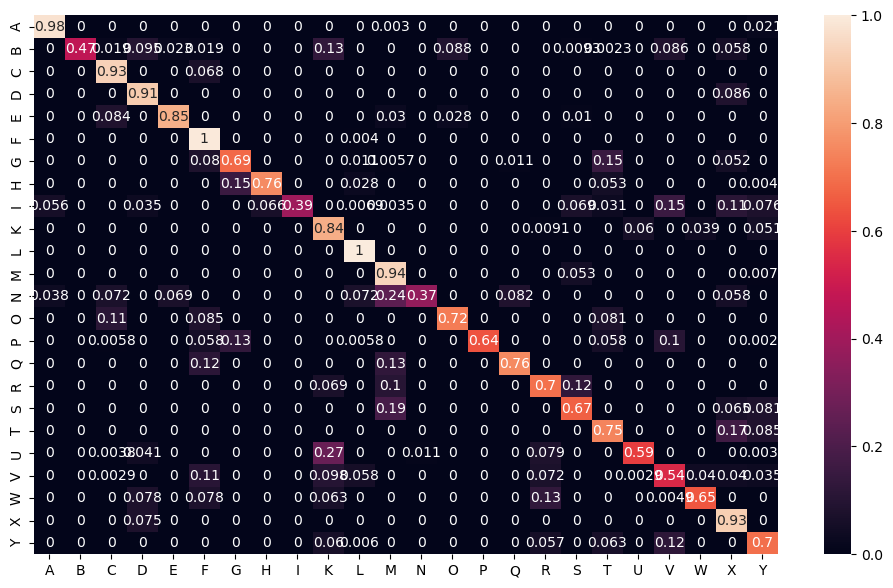

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Build confusion matrix
signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F',
         '6': 'G', '7': 'H', '8': 'I', '10': 'K', '11': 'L', '12': 'M',
         '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R', '18': 'S',
         '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
lst = signs.values()
lst = list(lst)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in lst],
                        columns=[i for i in lst])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
import numpy as np
import cv2
import torch

#from Model.network import Net

cap = cv2.VideoCapture(0)

cap.set(3, 700)
cap.set(4, 480)

device = "cpu"
model=VisionTransformer(
    img_size=28,
    patch_size=8,
    in_channels=1,
    embed_dim=64,
    num_heads=4,
    mlp_dim=128,
    num_layers=6,
    num_classes=25,
    device=device
)
model.to(device)
# if torch.cuda.is_available():
checkpoint = r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/weights/model_Vit_v2"
checkpoints=torch.load(checkpoint)
try:
    checkpoints.eval()
except AttributeError as error:
    print(error)

model.load_state_dict(checkpoints)
model.eval()

signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I',
        '10': 'K', '11': 'L', '12': 'M', '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R',
        '18': 'S', '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
while True:
    ret, frame = cap.read()
    img = frame[100:250, 100:250]

    res = cv2.resize(img, dsize=(28, 28), interpolation = cv2.INTER_CUBIC)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

    res1 = np.reshape(res, (1, 1, 28, 28)) / 255
    res2 = torch.from_numpy(res1)
    res3 = res2.type(torch.FloatTensor)

    out = model(res3)

    probs, label = torch.topk(out, 25)
    probs = torch.nn.functional.softmax(probs, 1)

    pred = out.max(1, keepdim=True)[1]

    if float(probs[0,0]) < 0.4:
        text = 'Sign not detected!'
    else:
        text = signs[str(int(pred))] + ': ' + '{:.2f}'.format(float(probs[0,0])) + '%'

    font = cv2.FONT_HERSHEY_SIMPLEX
    frame = cv2.putText(frame, text, (60,285), font, 1, (255,0,0), 2, cv2.LINE_AA)

    frame = cv2.rectangle(frame, (20, 20), (250, 250), (0, 255, 0), 3)

    cv2.imshow('Cam', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7112d0f27620>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 71123538c2f0, raw_cell="import numpy as np
import cv2
import torch

#from .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/cassanova/Documents/sign%20language%20classification/Pytorch-Sign-Language-Detection_CURRENT/SubmissionVit/vitransformer-very-detailed-tutorial.ipynb#X22sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

'collections.OrderedDict' object has no attribute 'eval'


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7112d0f27620>> (for post_run_cell), with arguments args (<ExecutionResult object at 7112337e6b10, execution_count=25 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 71123538c2f0, raw_cell="import numpy as np
import cv2
import torch

#from .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/cassanova/Documents/sign%20language%20classification/Pytorch-Sign-Language-Detection_CURRENT/SubmissionVit/vitransformer-very-detailed-tutorial.ipynb#X22sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

: 